# Importing Libraries:
Main libraries include pandas, numpy, matplotlib, and datetime

In [4]:
# !pip install certifi
# !pip install statsmodels --upgrade

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re
import warnings
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
# from google.colab import files

# Importing Excels:

The source for Excels is from https://www.gso.gov.vn/xuat-nhap-khau/. This is a website owned by the General Statistics Office, an agency under the Ministry of Planning and Investment. It manages and reports Vietnam's economic and social statistics.

The imported Excels summarize Vietnam's monthly exports by product categories from 2015 to 2022.


In [7]:
!wget https://www.gso.gov.vn/wp-content/uploads/2022/03/V01-2022-9.xls  --no-check-certificate -O 22.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2021/03/V01-2021-10.xls --no-check-certificate -O 21.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2020/10/V01-2020-4.xls  --no-check-certificate -O 20.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2019-2.xls   --no-check-certificate -O 19.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2018.xls     --no-check-certificate -O 18.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2017.xls     --no-check-certificate -O 17.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2016.xls     --no-check-certificate -O 16.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1_2015.xls.    --no-check-certificate -O 15.xls

--2023-11-08 19:59:52--  https://www.gso.gov.vn/wp-content/uploads/2022/03/V01-2022-9.xls
Resolving www.gso.gov.vn (www.gso.gov.vn)... 210.245.31.100
Connecting to www.gso.gov.vn (www.gso.gov.vn)|210.245.31.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 190464 (186K) [application/vnd.ms-excel]
Saving to: '22.xls'

22.xls              100%[===================>] 186.00K   103KB/s    in 1.8s    

2023-11-08 19:59:56 (103 KB/s) - '22.xls' saved [190464/190464]

--2023-11-08 19:59:57--  https://www.gso.gov.vn/wp-content/uploads/2021/03/V01-2021-10.xls
Resolving www.gso.gov.vn (www.gso.gov.vn)... 210.245.31.100
Connecting to www.gso.gov.vn (www.gso.gov.vn)|210.245.31.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 190976 (186K) [application/vnd.ms-excel]
Saving to: '21.xls'

21.xls              100%[===================>] 186.50K   

# Data Pre-processing:

There are eight Excels, each of which is a dataframe. All dataframes are put into a dictionary called "dfs" for concatenation later.

Each df can be accessed using "df_name" as a variable. They have to be processed so that redundant columns and rows are eliminated. In the end, there will be 13 columns (including index) and six rows (five chosen categories and the timeline)

In [8]:
# Create a list of year names that match the uploaded database
list_of_years = [f'{i}.xls' for i in range (15,23)]
dfs = {}

# Enumerate will create a tuple
for i, each_year in enumerate(list_of_years):
    # Create dataframe name that matches each Excel year
    df_name = f"df{each_year[:-4]}"
    # Use dfs[df_name] to refer to each df from this point
    dfs[df_name] = pd.read_excel(each_year)
    # Extract year to rename columns later
    year = re.search(r'\d+', each_year).group()


    ### Pre-Processing df of one year ###

    # Delete redundant rows and columns
    x='ĐVT'
    if dfs[df_name]['Unnamed: 1'].str.contains(x).any():
        dfs[df_name] = dfs[df_name].drop('Unnamed: 1',axis=1)

    dfs[df_name]= dfs[df_name].iloc[:, ::2]
    dfs[df_name]= dfs[df_name].iloc[:,:13]

    dfs[df_name].rename(columns=dfs[df_name].iloc[1],inplace=True)
    dfs[df_name] = dfs[df_name].dropna(subset=['Tên hàng'])
    dfs[df_name]=dfs[df_name].iloc[1:]

    # Index and rename columns with format MM/YY
    dfs[df_name]=dfs[df_name].set_index('Tên hàng', inplace=False)
    columns_name = [f'{month}/{year}' for month in range(1,13)]
    dfs[df_name].columns = columns_name

    # Filter to five cateogories with highest potential growth
    dfs[df_name] = dfs[df_name].loc[dfs[df_name].index.str.contains('hải|sản phẩm gỗ|dệt may|sắt|vi tính')]

dfs['df22']
# dfs

,1/22,2/22,3/22,4/22,5/22,6/22,7/22,8/22,9/22,10/22,11/22,12/22
Tên hàng,,,,,,,,,,,,
Hàng hải sản,872493.336,635366.207,1015927.918,1126138.725,1056067.376,999007.81,936417.054,991971.4,855212.623,897202.552,784440.765,753191.124
Gỗ và sản phẩm gỗ,1549310.749,890952.098,1538602.971,1616203.012,1394158.535,1407014.678,1320480.119,1440135.173,1118225.738,1211470.349,1200663.812,1323930.505
Hàng dệt may,3571336.194,2065292.683,3041730.052,3153379.948,3168068.204,3530808.064,3709007.293,4045062.989,2729365.914,2715943.605,2915583.825,2921066.766
Sản phẩm từ sắt thép,424127.327,294632.437,447854.67,439608.593,411356.334,401854.174,388521.572,428843.382,359794.291,328824.032,361962.096,363800.484
"Máy vi tính, sản phẩm điện tử & linh liện",4109864.137,3844660.029,5285704.388,4467755.676,4805859.038,5167119.202,4040649.656,4988923.072,5134612.548,4777099.349,4119441.26,4794748.807


# Data Consolidation:

Data is renamed into English and collapsed from months to quarters. In total, there are 32 quarters from Q1 2015 to Q4 2022

In [37]:
# Concatenate all dataframes into one
df_all = pd.concat(dfs.values(), axis=1)

# Transpose and translate columns to English
df_all = df_all.T
df_all = df_all.rename(columns={'Hàng hải sản':'Seafoods',
                                'Gỗ và sản phẩm gỗ':'Wood & Products from Wood',
                                'Hàng dệt may':'Textile',
                                'Sản phẩm từ sắt thép':'Steel & Products from Steel',
                                'Máy vi tính, sản phẩm điện tử & linh liện':'Electronics'})



# Group months into quarters and change format to MM/YYYY
df_all.index = pd.to_datetime(df_all.index, format='%m/%y')

df_quarter = df_all.resample('Q').sum()

df_quarter.index = df_quarter.index.strftime('%m/%Y')


display(df_quarter)

'''
# Download the Excel file to the local machine
df_quarter.to_excel('my_data.xlsx', index=True)
files.download('my_data.xlsx')
# '''


Tên hàng,Seafoods,Wood & Products from Wood,Textile,Steel & Products from Steel,Electronics
03/2015,1366399.628,1530759.749,4.887089e+06,426961.150,3.568708e+06
06/2015,1670496.830,1668160.919,5.469779e+06,456198.286,3.806313e+06
09/2015,1819308.650,1744995.740,6.823056e+06,451153.279,3.997303e+06
12/2015,1867828.307,1987255.943,5.895207e+06,435790.892,4.281364e+06
03/2016,1408853.597,1519223.934,5.125443e+06,440163.165,3.734117e+06
06/2016,1675185.572,1695375.329,5.721721e+06,502664.388,4.143020e+06
09/2016,1931436.927,1765321.535,6.938714e+06,516447.925,5.016001e+06
12/2016,2037649.463,1989175.522,6.055482e+06,525553.854,6.065973e+06
03/2017,1511225.550,1780029.487,5.623523e+06,501148.776,5.519562e+06
06/2017,2075967.607,1876699.029,6.125398e+06,545164.805,6.038466e+06


"\n# Download the Excel file to the local machine\ndf_quarter.to_excel('my_data.xlsx', index=True)\nfiles.download('my_data.xlsx')\n# "

#Date Exploratory:
Visualize the trends of five categories by plotting the numbers in the line graph



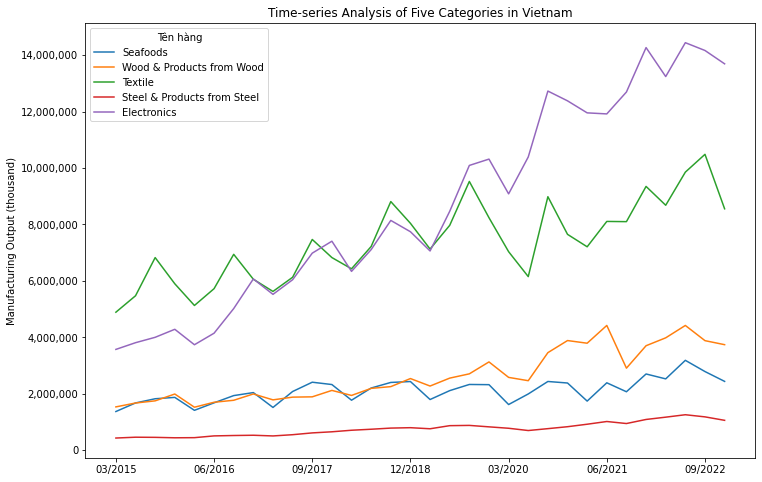

In [10]:
ax = df_quarter.plot(figsize=(12, 8), grid=0)

# Set y-axis tick label format to reveal all numbers
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Set y axis and title labels
ax.set_ylabel('Manufacturing Output (thousand)')
plt.title('Time-series Analysis of Five Categories in Vietnam')

# Show the plot
plt.show()
plt.close()

#Picking the category:
From our observation above, electronics can be seen to have the greatest growth
potential so we will choose it for further forecasting


In [11]:
df_etron = df_quarter['Electronics']

# Check the info, make sure quarters are datetime and indexed
df_etron.info()


<class 'pandas.core.series.Series'>
Index: 32 entries, 03/2015 to 12/2022
Series name: Electronics
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 512.0+ bytes


We can then visualize the trend with only Electronics data

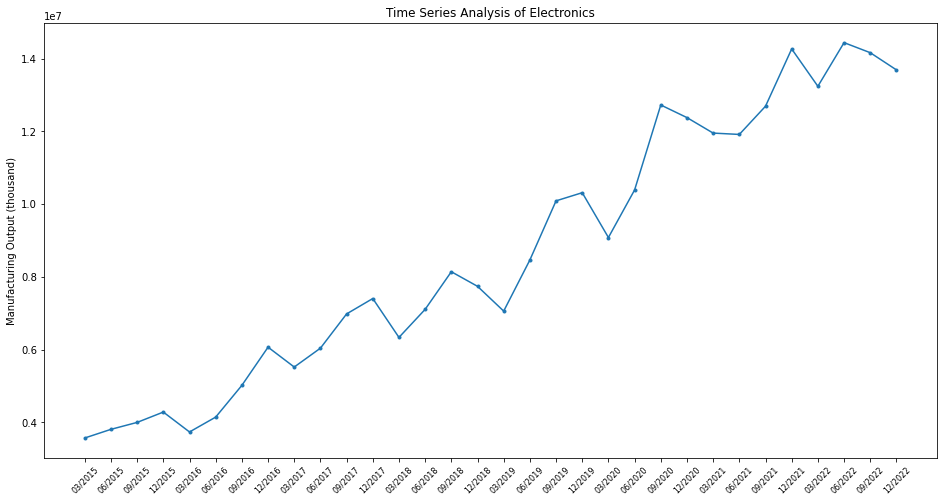

In [12]:
# Visualize the trend
plt.figure(figsize=(16,8))
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('Manufacturing Output (thousand)',fontsize=10)
plt.title('Time Series Analysis of Electronics')

plt.plot(df_etron, marker='.')


*Note that 1e7 is equivalent to 10,000,000

#Splitting the dataset:
The ratio of data used for train vs. test is around 80/20, or that 26 months for training and 6 months for testing data

In [40]:
# Splitting the data into train and test
df_train, df_test = df_etron.iloc[:-6], df_etron.iloc[-6:]
print(df_train)
print(df_test)

03/2015    3.568708e+06
06/2015    3.806313e+06
09/2015    3.997303e+06
12/2015    4.281364e+06
03/2016    3.734117e+06
06/2016    4.143020e+06
09/2016    5.016001e+06
12/2016    6.065973e+06
03/2017    5.519562e+06
06/2017    6.038466e+06
09/2017    6.980333e+06
12/2017    7.403732e+06
03/2018    6.334405e+06
06/2018    7.106280e+06
09/2018    8.140554e+06
12/2018    7.739629e+06
03/2019    7.057903e+06
06/2019    8.463563e+06
09/2019    1.008999e+07
12/2019    1.031411e+07
03/2020    9.081868e+06
06/2020    1.038940e+07
09/2020    1.272592e+07
12/2020    1.237920e+07
03/2021    1.195330e+07
06/2021    1.191610e+07
Name: Electronics, dtype: float64
09/2021    1.269216e+07
12/2021    1.426732e+07
03/2022    1.324023e+07
06/2022    1.444073e+07
09/2022    1.416419e+07
12/2022    1.369129e+07
Name: Electronics, dtype: float64


#Stationarity Testing:
Test whether the dataset is stationary or not. This step is important for time-series analysis to make forecasting and modeling more accurate

In [14]:
result = adfuller(df_train)
print(result[1])

0.999025530207005


The null hypothesis for the adfuller test is that the dataset is non-stationary. Since the result returns that the **p-value** is **0.99**, which is higher than 0.05 (significance level), we fail to reject the null hypothesis. In other words, the series is non-stationary. This makes sense because the series shows an upward trend in the graph above.

#Changing the series to stationary:
Use log and diff to make the dataset stationary


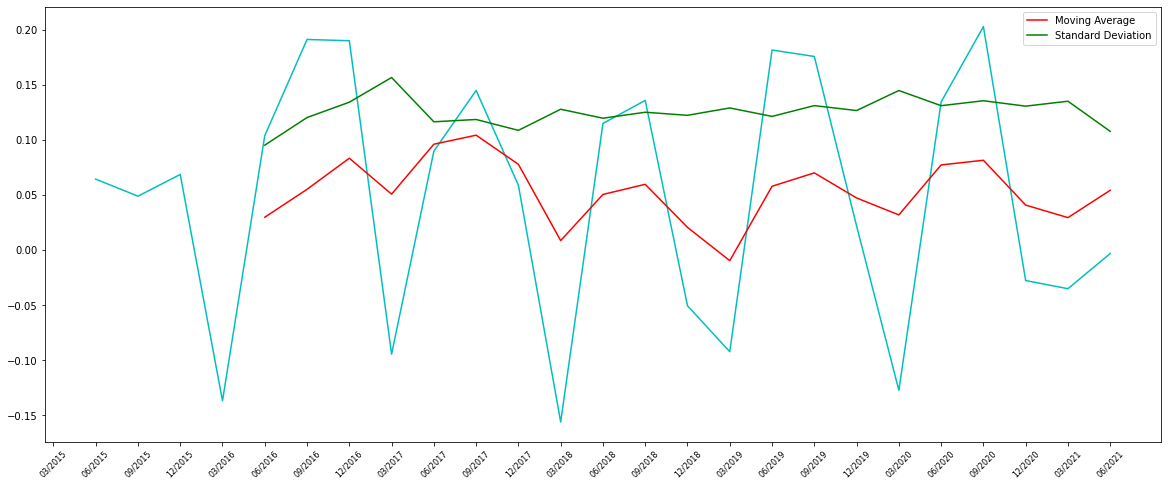

In [15]:
# Use log to stabalize the variance
df_log = np.log(df_train)

# Plot the data
plt.figure(figsize=(20,8))
plt.xticks(fontsize=8, rotation=45)
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=5).mean()
MStd_shift = df_shift.rolling(window=5).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

The moving average (red) and standard deviation (green) lines exhibit insignificant fluctuation over time. Now, we can retest using adfuller function

In [16]:
df_shift = df_shift.dropna()
print(adfuller(df_shift)[1])

0.01257757603805411


In [17]:
print(df_shift.index)

Index(['06/2015', '09/2015', '12/2015', '03/2016', '06/2016', '09/2016',
       '12/2016', '03/2017', '06/2017', '09/2017', '12/2017', '03/2018',
       '06/2018', '09/2018', '12/2018', '03/2019', '06/2019', '09/2019',
       '12/2019', '03/2020', '06/2020', '09/2020', '12/2020', '03/2021',
       '06/2021'],
      dtype='object')


Since **p-value** of **0.01** is lower than significance level of **0.05**, we can reject the null hypothesis and conclude that the series is stationary

#Finding model terms for ARIMA model:
Here, we would find the best values for p, d, and q to put into the ARIMA model. The combinations that give the best aic results will be tried and compared using RMSE values. The model with the lowest RMSE will be chosen

The first model to be tested has d equal 0

In [43]:
order_aic=[]

# Go over all possible combinations of p and q
for p in range(6):
    for q in range(6):
        model=ARIMA(df_shift, order=(p,0,q)) # Assume d = 0
        results=model.fit()

        order_aic.append((p,q,results.aic))

order_df = pd.DataFrame(order_aic,columns=['p','q','AIC'])

# Sort AIC values from lowest to highest
warnings.filterwarnings('ignore')
print(order_df.sort_values('AIC'))

    p  q        AIC
31  5  1 -54.756944
32  5  2 -54.445513
15  2  3 -51.859714
30  5  0 -51.823099
17  2  5 -50.673878
24  4  0 -50.201641
19  3  1 -49.952194
16  2  4 -49.877218
25  4  1 -49.848930
20  3  2 -49.817706
21  3  3 -49.810932
27  4  3 -49.628052
33  5  3 -49.510814
26  4  2 -49.294109
28  4  4 -48.822070
14  2  2 -48.705240
22  3  4 -48.135989
23  3  5 -47.694567
34  5  4 -47.273554
18  3  0 -47.248070
29  4  5 -46.792698
4   0  4 -46.741614
9   1  3 -46.318061
5   0  5 -45.634545
12  2  0 -45.593287
13  2  1 -45.485561
10  1  4 -45.400537
11  1  5 -44.276911
35  5  5 -43.551810
3   0  3 -42.152093
8   1  2 -41.415625
7   1  1 -39.683437
1   0  1 -39.642557
0   0  0 -35.159659
6   1  0 -33.218694
2   0  2 -14.777364


In [44]:
order_aic=[]

for p in range(6):
    for q in range(6):
        model=ARIMA(df_shift, order=(p,1,q)) # Assume d = 1
        results=model.fit()

        order_aic.append((p,q,results.aic))

order_df = pd.DataFrame(order_aic,columns=['p','q','AIC'])
print(order_df.sort_values('AIC'))

    p  q          AIC
18  3  0   -45.638150
24  4  0   -44.269119
19  3  1   -44.259839
31  5  1   -43.910775
21  3  3   -43.559424
26  4  2   -42.614564
20  3  2   -42.361478
30  5  0   -42.314852
25  4  1   -42.282056
22  3  4   -42.199898
32  5  2   -42.023124
27  4  3   -41.928588
16  2  4   -41.840028
15  2  3   -41.580084
23  3  5   -40.390986
17  2  5   -40.280419
33  5  3   -40.275125
28  4  4   -40.196361
13  2  1   -38.187756
34  5  4   -38.123796
14  2  2   -37.469534
10  1  4   -36.404903
5   0  5   -36.288111
11  1  5   -35.299492
3   0  3   -34.184179
4   0  4   -31.951094
9   1  3   -29.531286
1   0  1   -29.393155
2   0  2   -27.471282
7   1  1   -27.395634
8   1  2   -26.370496
12  2  0   -26.208541
0   0  0   -16.931895
6   1  0   -15.977625
29  4  5  4073.334957
35  5  5  4075.335328


The model with d=0 produces lower AIC so we will stick to that model, using p=5, d=0, q=1 because its AIC value is lowest, at -54.76. The model has now become ARMA. Now, the next step is to fit the model using the above combination

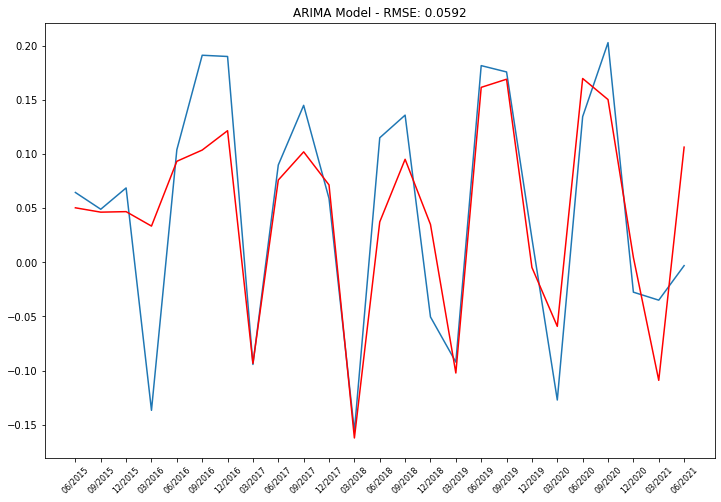

In [45]:
# Fit the model
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(12,8))
model_ARMA = ARIMA(df_shift, order=(5,0,1)) # Using p=5, d=0, q=1
results_ARMA = model_ARMA.fit()
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.xticks(fontsize=8, rotation=45)
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, df_shift, squared=False)) # Calculate RMSE value to measure its prediction error
plt.show()

An RMSE value of 0.0592 suggests that the model's predictive performance is relatively strong

In [21]:
results_ARMA.fittedvalues

06/2015    0.050301
09/2015    0.046277
12/2015    0.046757
03/2016    0.033413
06/2016    0.093270
09/2016    0.103631
12/2016    0.121524
03/2017   -0.093467
06/2017    0.075939
09/2017    0.101979
12/2017    0.071428
03/2018   -0.162303
06/2018    0.037271
09/2018    0.095107
12/2018    0.034920
03/2019   -0.102284
06/2019    0.161546
09/2019    0.169067
12/2019   -0.004808
03/2020   -0.059204
06/2020    0.169747
09/2020    0.150264
12/2020    0.004495
03/2021   -0.109056
06/2021    0.106336
dtype: float64

In [22]:
results_ARMA.aic

-54.75694434619167

# Inverse Transformation
Use inverse transformation to get back the original values. Compare the predicted training data with the original one

In [23]:
predictions = pd.Series(results_ARMA.fittedvalues)
predictions

06/2015    0.050301
09/2015    0.046277
12/2015    0.046757
03/2016    0.033413
06/2016    0.093270
09/2016    0.103631
12/2016    0.121524
03/2017   -0.093467
06/2017    0.075939
09/2017    0.101979
12/2017    0.071428
03/2018   -0.162303
06/2018    0.037271
09/2018    0.095107
12/2018    0.034920
03/2019   -0.102284
06/2019    0.161546
09/2019    0.169067
12/2019   -0.004808
03/2020   -0.059204
06/2020    0.169747
09/2020    0.150264
12/2020    0.004495
03/2021   -0.109056
06/2021    0.106336
dtype: float64

In [24]:
# Cumulative sum before exponential transformation
predictions_cumsum = predictions.cumsum()
predictions_cumsum

06/2015    0.050301
09/2015    0.096578
12/2015    0.143335
03/2016    0.176748
06/2016    0.270018
09/2016    0.373649
12/2016    0.495173
03/2017    0.401706
06/2017    0.477644
09/2017    0.579623
12/2017    0.651051
03/2018    0.488748
06/2018    0.526019
09/2018    0.621126
12/2018    0.656046
03/2019    0.553762
06/2019    0.715308
09/2019    0.884375
12/2019    0.879568
03/2020    0.820363
06/2020    0.990110
09/2020    1.140374
12/2020    1.144869
03/2021    1.035812
06/2021    1.142149
dtype: float64

In [25]:
# Add first value of log series to predictions_cumsum
predictions_log = pd.Series(df_log.iloc[0], index=df_log.index)

# Add prediction_cumsum to prediction_log with the same monthly index
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log.index = pd.to_datetime(predictions_log.index, format="%m/%Y")

# Sort by month
predictions_log = predictions_log.sort_index()
predictions_log.index = predictions_log.index.strftime("%m/%Y")
predictions_log

03/2015    15.087714
06/2015    15.138016
09/2015    15.184292
12/2015    15.231049
03/2016    15.264462
06/2016    15.357732
09/2016    15.461363
12/2016    15.582887
03/2017    15.489420
06/2017    15.565359
09/2017    15.667338
12/2017    15.738765
03/2018    15.576462
06/2018    15.613733
09/2018    15.708840
12/2018    15.743760
03/2019    15.641476
06/2019    15.803022
09/2019    15.972090
12/2019    15.967282
03/2020    15.908077
06/2020    16.077824
09/2020    16.228088
12/2020    16.232583
03/2021    16.123526
06/2021    16.229863
dtype: float64

In [26]:
# Apply exponential transformation
predictions_ARMA = np.exp(predictions_log)
predictions_ARMA

03/2015    3.568708e+06
06/2015    3.752810e+06
09/2015    3.930559e+06
12/2015    4.118705e+06
03/2016    4.258647e+06
06/2016    4.674966e+06
09/2016    5.185430e+06
12/2016    5.855471e+06
03/2017    5.332975e+06
06/2017    5.753729e+06
09/2017    6.371449e+06
12/2017    6.843194e+06
03/2018    5.817969e+06
06/2018    6.038902e+06
09/2018    6.641445e+06
12/2018    6.877459e+06
03/2019    6.208787e+06
06/2019    7.297353e+06
09/2019    8.641524e+06
12/2019    8.600077e+06
03/2020    8.105694e+06
06/2020    9.605286e+06
09/2020    1.116269e+07
12/2020    1.121298e+07
03/2021    1.005446e+07
06/2021    1.118252e+07
dtype: float64

Now, we can visualize and compare the predicted with the actual datasets

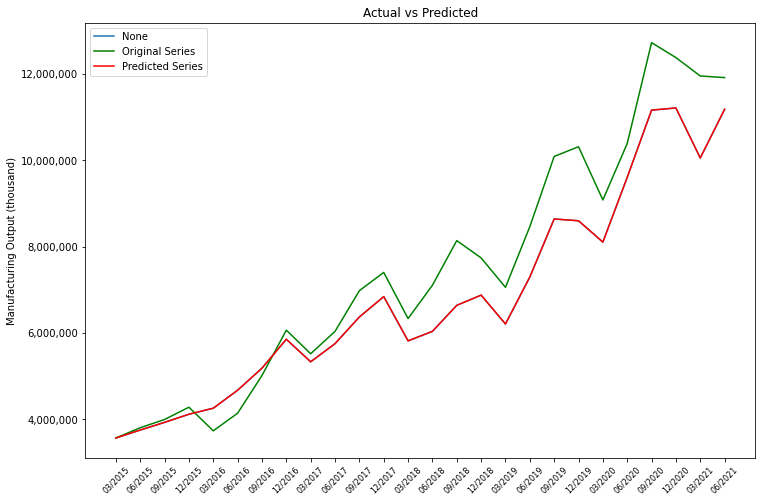

In [27]:
import matplotlib.dates as mdates
from datetime import datetime


# Plotting the original vs predicted series
ax = predictions_ARMA.plot(figsize=(12, 8), grid=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.plot(df_train, color = 'g', label = 'Original Series')
ax.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')
ax.set_ylabel('Manufacturing Output (thousand)')


x_labels = df_train.index.tolist()
x_ticks = range(len(x_labels))
plt.xticks(x_ticks, x_labels, fontsize=8, rotation=45)
plt.title('Actual vs Predicted')
plt.xticks(fontsize=8, rotation=45)
plt.legend()
plt.show()

# Forecasting the data for the next six quarters
Forecast future data with predictions_ARMA and compare it with test data

In [28]:
#Forecasting the values for next six quarters
forecasted_ARMA = results_ARMA.forecast(steps=6)
forecasted_ARMA.index = pd.to_datetime(forecasted_ARMA.index, format="%m/%Y")
forecasted_ARMA.index = forecasted_ARMA.index.strftime("%m/%Y")
forecasted_ARMA

09/2021    0.178438
12/2021   -0.006876
03/2022    0.010970
06/2022    0.042599
09/2022    0.188117
12/2022    0.006970
Name: predicted_mean, dtype: float64

In [29]:
#Creating a series of cumulative sum
forecasted_cumsum = forecasted_ARMA.cumsum()
forecasted_cumsum

09/2021    0.178438
12/2021    0.171562
03/2022    0.182532
06/2022    0.225131
09/2022    0.413248
12/2022    0.420219
Name: predicted_mean, dtype: float64

In [30]:
#Making a new dataframe to get the indices from 2020-2021
index = pd.date_range('2021-09-01','2022-12-01' , freq='3M')
df1 = pd.DataFrame()
df1['cumsum'] = forecasted_cumsum
df1

,cumsum
09/2021,0.178438
12/2021,0.171562
03/2022,0.182532
06/2022,0.225131
09/2022,0.413248
12/2022,0.420219


In [31]:
#Adding last value of the log of the training data
df1['Forecasted'] = df1['cumsum'] + float(df_log.loc['06/2021'])
df1

,cumsum,Forecasted
09/2021,0.178438,16.471839
12/2021,0.171562,16.464963
03/2022,0.182532,16.475933
06/2022,0.225131,16.518532
09/2022,0.413248,16.706649
12/2022,0.420219,16.713620


In [32]:
#Applying exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(df1['Forecasted'])

forecasted_ARMA

09/2021    1.424390e+07
12/2021    1.414629e+07
03/2022    1.430233e+07
06/2022    1.492476e+07
09/2022    1.801381e+07
12/2022    1.813982e+07
Name: Forecasted, dtype: float64

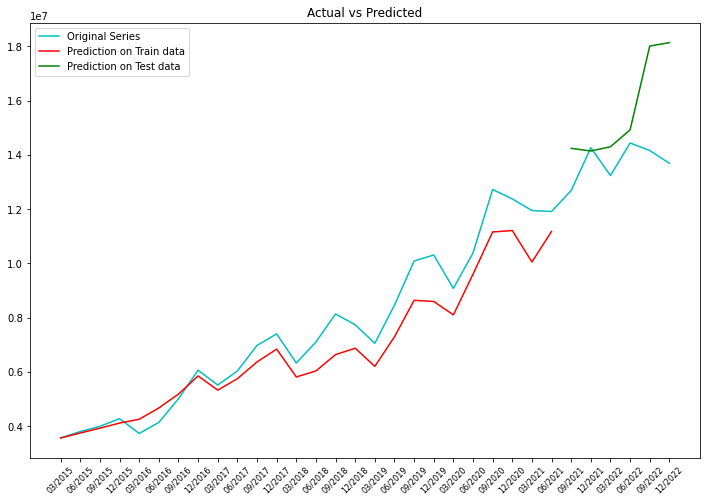

In [33]:
#Plotting the original vs predicted series
plt.figure(figsize=(12,8))
plt.plot(df_etron, color = 'c', label = 'Original Series')
plt.plot(predictions_ARMA, color = 'r', label = 'Prediction on Train data')
plt.plot(forecasted_ARMA, label = 'Prediction on Test data', color='g')
x_labels = df_etron.index.tolist()
x_ticks = range(len(x_labels))
plt.xticks(x_ticks, x_labels, fontsize=8, rotation=45)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()